# Predicting Bike Rentals

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from data_science_util import *

In [138]:
# Function to test the model with the test set

def set_fold_number(df,k):
    rows_per_fold = int(len(df)/k)
    df['fold'] = 1
    for i in range(0,len(df)-1):
        df.loc[i, 'fold'] = int((i+1)/rows_per_fold)+1

def train_and_test(df, feature_cols, target_column,k=2):
    print("Train a test")
    total_rows = len(df)    
    if k > 2:
        # Perform k-cross-fold validation
        # Shuffle the original dataset
        # Split dataset into k parts
        # Train the model on one part, predict labels on the other part
        # Assess the error
        # Switch training and test sets and repeat
        num_folds = k
        shuffled_index = np.random.permutation(df.index)
        df = df.reindex(shuffled_index).copy()
        set_fold_number(df, num_folds)
        fold_metrics = {}
        for i in range(1,num_folds+1):
            #print("K-Fold validation - Test fold:"+str(i))
            #feature_cols = list(df.columns)
            if target_column in feature_cols:
                feature_cols.remove(target_column)
            lr = LinearRegression()
            train = df.loc[df['fold'] != i].copy()
            test = df.loc[df['fold'] == i].copy()
            lr.fit(train[feature_cols],train[target_column])
            test_predictions = lr.predict(test[feature_cols])
            metrics = evaluate_model(test_predictions,test[target_column].to_numpy(),feature_cols)
            fold_metrics[i] = metrics
        print(pd.DataFrame.from_dict(fold_metrics,orient='index',columns=['Mean Square Error',
                                                                          'Root Mean Square Error',
                                                                          'Mean Absolute Error',
                                                                          'Median Absolute Error',
                                                                          'R^2','Adjusted R^2']))
        return   
    else:
        #perform k-cross-fold validation
        #test_rmse = 0
        return
    return

def train_and_test_w_features(df, feature_cols, target_column, regressor, k=2):
    total_rows = len(df)    
    for i in range(len(feature_cols)):
        test_features = feature_cols[:i+1]
        print("Results for features "+str(test_features))
        if k > 2:
            # Perform k-cross-fold validation
            # Shuffle the original dataset
            # Split dataset into k parts
            # Train the model on one part, predict labels on the other part
            # Assess the error
            # Switch training and test sets and repeat
            num_folds = k
            shuffled_index = np.random.permutation(df.index)
            df = df.reindex(shuffled_index).copy()
            set_fold_number(df, num_folds)
            fold_metrics = {}
            for i in range(1,num_folds+1):
                #print("K-Fold validation - Test fold:"+str(i))
                #feature_cols = list(df.columns)
                if target_column in feature_cols:
                    feature_cols.remove(target_column)
                train = df.loc[df['fold'] != i].copy()
                test = df.loc[df['fold'] == i].copy()
                regressor.fit(train[feature_cols],train[target_column])
                test_predictions = regressor.predict(test[feature_cols])
                metrics = evaluate_model(test_predictions,test[target_column].to_numpy(),feature_cols)
                fold_metrics[i] = metrics
            print(pd.DataFrame.from_dict(fold_metrics,orient='index',columns=['Mean Square Error',
                                                                              'Root Mean Square Error',
                                                                              'Mean Absolute Error',
                                                                              'Median Absolute Error',
                                                                              'R^2','Adjusted R^2']))  
        #else:
            #perform k-cross-fold validation
            #test_rmse = 0
    return

# Functions to transform features

def remove_missing_values(df,threshold=.25):
    total_rows = len(df)
    # df_null_counts is now a series with indexes of column names and values of the number of null rows in that column
    df_null_counts = df.isnull().sum()

    # get a list of all columns with between 1 and the threshold percentage of null values - these are candidates for imputing the missing values
    # columns/features that have more than the threshold percentage of null values will be dropped
    cols_to_keep = df_null_counts[(df_null_counts >= 0) & (df_null_counts < (threshold*total_rows))].index
    col_diff = len(df.columns)-len(cols_to_keep)
    print("Removing %d features because of excess null values" % col_diff)
    #print("Keeping %s " % list(cols_to_keep))
    #print(df_null_counts)
    return df[cols_to_keep]

def impute_missing_values(df,threshold=.05,statistic='mode'):
    total_rows = len(df)
    df_null_counts = df.isnull().sum()
    cols_to_impute = df_null_counts[(df_null_counts > 0) & (df_null_counts < (threshold*total_rows))].copy().index
    print("Imputing values for "+str(len(cols_to_impute))+" columns")
    for col in cols_to_impute:
        if statistic == 'mode':
            df[col] = df[col].fillna(df[col].mode(),inplace=True)
        elif statistic == 'median':
            df[col] = df[col].fillna(df[col].mean(),inplace=True)
    return df

def convert_categorical_vars(df):
    text_cols = df.select_dtypes(include=['object']).columns
    print(" %d features to be converted from text to categorical" % len(text_cols))
    #print(df.dtypes)
    for col in text_cols:
        cat_col = pd.Categorical(df[col])
        df[col] = cat_col.codes
    return df

def scale_numeric_vars(df):
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns
    print(" %d features to be scaled" % len(numeric_cols))
    #print(df.dtypes)
    for col in numeric_cols:
        col_mean = df[col].mean()
        col_range = df[col].max()-df[col].min()
        df[col] = df[col].apply(lambda x: (float(x)-col_mean)/col_range)
    return df

def encode_categorical_cols(df):
    categorical_cols = df.select_dtypes(include=['category']).columns
    print(" %d categorical eatures to be encoded with one-hot encoding" % len(categorical_cols))
    dummy_cols = pd.DataFrame()
    dummy_cols = pd.get_dummies(df, columns=categorical_cols)
    return dummy_cols

def transform_features(df):
    # Perform some basic feature engineering tasks on the data set:
    # 1. Remove features with more than X% missing values
    # 2. Impute values for features where fewer than Y% of the rows have mssing values
    # 3. Convert string/object data in the data frame to categorical type
    # 4. Convert cetegorical features to a one-hot encoding or dummy encoding
    print("Beginning transformation with "+str(len(df.columns))+" features/columns")
    #print(df.columns)
    new_df = remove_missing_values(df)
    new_df = impute_missing_values(new_df)
    new_df = scale_numeric_vars(new_df)
    new_df = convert_categorical_vars(new_df)
    new_df = encode_categorical_cols(new_df)
    #training_rows = len(new_df)*training_rate
    print("Concluding transformation with "+str(len(new_df.columns))+" features/columns")
    #print(new_df.columns)
    #return new_df[:training_rows]
    return new_df

def train_test_split(df, ratio):
    total_rows = df.shape[0]
    train = df.sample(frac=ratio)
    non_selected_rows = df.index.isin(train.index)
    test = df.loc[~non_selected_rows]
    return train, test

def print_metrics(y_true, y_predicted, n_parameters, verbose=False):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    mse = sklm.mean_squared_error(y_true, y_predicted)
    rmse = math.sqrt(sklm.mean_squared_error(y_true, y_predicted))
    mae = sklm.mean_absolute_error(y_true, y_predicted)
    medar = sklm.median_absolute_error(y_true, y_predicted)

    ## Print the usual metrics and the R^2 values
    if verbose:
        print('Mean Square Error      = ' + str( mse ))
        print('Root Mean Square Error = ' + str( rmse ))
        print('Mean Absolute Error    = ' + str( mae ))
        print('Median Absolute Error  = ' + str( medar ))
        print('R^2                    = ' + str(r2))
        print('Adjusted R^2           = ' + str(r2_adj))
    # return {"mean_square_error":mse,"root_mean_square_error":rmse,"mean_absolute_error":mae,"median_absolute_error":medar,"r^2":r2,"adj_r2":r2_adj}
    return [mse,rmse,mae,medar,r2,r2_adj]

def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    plt.show()

def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    plt.show()

def evaluate_model(predictions, actuals, features, verbose=False):
    #y_score = lin_mod.predict(x_test) 
    metrics = print_metrics(actuals, predictions, len(features), verbose) 
    if verbose:
        hist_resids(actuals, predictions)  
        resid_qq(actuals, predictions)  
        resid_plot(actuals, predictions) 
    return metrics

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
hourly_bike_rentals = pd.read_csv("bike_rental_hour.csv")
hourly_bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Dictionary



## Exploratory Data Analysis

In [53]:
print(hourly_bike_rentals.columns)
print(hourly_bike_rentals.dtypes)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
time_label      int64
dtype: object


In [59]:
def plot_bars(df, cols):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        counts = df[col].value_counts() # find the counts for each unique category
        counts.plot.bar(ax = ax, color = 'blue') # Use the plot.bar method on the counts data frame
        ax.set_title('Bike rentals by ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Bike rentals')# Set text for y axis
        #ax.margins(0.05)
    plt.show()
    
def plot_hist(df, cols):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        df.hist(col)
        #ax.set_title('Bike rentals by ' + col) # Give the plot a main title
        #ax.set_xlabel(col) # Set text for the x axis
        #ax.set_ylabel('Bike rentals')# Set text for y axis
        #ax.margins(0.05)
    plt.show()

In [ ]:
plot_hist(hourly_bike_rentals,hourly_bike_rentals.columns)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001886B20CCC0>]],
      dtype=object)

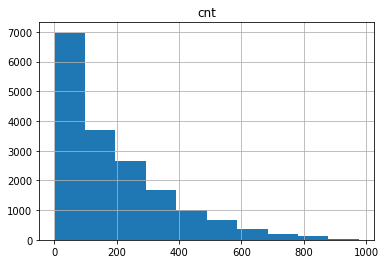

In [6]:
hourly_bike_rentals.hist("cnt")

In [7]:
correlations = hourly_bike_rentals.corr()

In [8]:
print(correlations)

             instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.404046  0.866014  0.489164 -0.004775  0.014723   
season      0.404046  1.000000 -0.010742  0.830386 -0.006117 -0.009585   
yr          0.866014 -0.010742  1.000000 -0.010473 -0.003867  0.006692   
mnth        0.489164  0.830386 -0.010473  1.000000 -0.005772  0.018430   
hr         -0.004775 -0.006117 -0.003867 -0.005772  1.000000  0.000479   
holiday     0.014723 -0.009585  0.006692  0.018430  0.000479  1.000000   
weekday     0.001357 -0.002335 -0.004485  0.010400 -0.003498 -0.102088   
workingday -0.003416  0.013743 -0.002196 -0.003477  0.002285 -0.252471   
weathersit -0.014198 -0.014524 -0.019157  0.005400 -0.020203 -0.017036   
temp        0.136178  0.312025  0.040913  0.201691  0.137603 -0.027340   
atemp       0.137615  0.319380  0.039222  0.208096  0.133750 -0.030973   
hum         0.009577  0.150625 -0.083546  0.164411 -0.276498 -0.010588   
windspeed  -0.074505 -0.149773 -0.0087

In [43]:
cnt_corr = hourly_bike_rentals.corr()["cnt"]
cnt_corr.sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

In [44]:
cnt_corr.sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
time_label   -0.378318
Name: cnt, dtype: float64

## Feature Engineering

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [45]:
def assign_label(value):
    # 4 -> night - 12midnight to 6am
    if value < 6:
        return 4
    # 1 -> morning - 6am to 12noon
    elif value < 12:
        return 1
    # 2 -> afternoon - 12noon to 6pm
    elif value < 18:
        return 2
    # 3 - evening - 6pm to 
    elif value < 24:
        return 3
    else:
        return 0

In [140]:
hourly_bike_rentals["time_label"] = hourly_bike_rentals["hr"].apply(assign_label)

In [141]:
hourly_bike_rentals["time_label"].head(5)

0    4
1    4
2    4
3    4
4    4
Name: time_label, dtype: int64

In [142]:
hourly_bike_rentals.shape

(17379, 18)

# Metric selection

Because the goal is predicting a continuous variable, typical regression metrics such as Mean Squared Error, Root Mean Squared and R^2 will be used to assess the models.

## Feature Selection



In [143]:
# Get a list of all correlation values relative to the cnt column
cnt_corr = hourly_bike_rentals.corr()["cnt"]
highly_correlated_features = list(cnt_corr.sort_values(ascending = False).index)

# These features are being removed because the target column is derived from them
features_to_remove = ['cnt','casual','dteday','registered']
for col in features_to_remove:
    if col in highly_correlated_features:
        highly_correlated_features.remove(col)
    
print(highly_correlated_features)

['temp', 'atemp', 'hr', 'instant', 'yr', 'season', 'mnth', 'windspeed', 'workingday', 'weekday', 'holiday', 'weathersit', 'hum', 'time_label']


## Feature Engineering

In [144]:
print(highly_correlated_features)

['temp', 'atemp', 'hr', 'instant', 'yr', 'season', 'mnth', 'windspeed', 'workingday', 'weekday', 'holiday', 'weathersit', 'hum', 'time_label']


In [145]:
refined_df = transform_features(hourly_bike_rentals)

Beginning transformation with 18 features/columns
Removing 0 features because of excess null values
Imputing values for 0 columns
 17 features to be scaled
 1 features to be converted from text to categorical
 0 categorical eatures to be encoded with one-hot encoding
Concluding transformation with 18 features/columns


In [146]:
refined_df.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,-0.500000,0,-0.500547,-0.502561,-0.503434,-0.502033,-0.02877,0.499386,-0.682721,-0.141761,-0.262232,-0.187875,0.182771,-0.22346,-0.089036,-0.158902,-0.177729,0.502484
1,-0.499942,0,-0.500547,-0.502561,-0.503434,-0.458554,-0.02877,0.499386,-0.682721,-0.141761,-0.282640,-0.203075,0.172771,-0.22346,-0.075412,-0.137457,-0.153138,0.502484
2,-0.499885,0,-0.500547,-0.502561,-0.503434,-0.415076,-0.02877,0.499386,-0.682721,-0.141761,-0.282640,-0.203075,0.172771,-0.22346,-0.083586,-0.143100,-0.161335,0.502484
3,-0.499827,0,-0.500547,-0.502561,-0.503434,-0.371598,-0.02877,0.499386,-0.682721,-0.141761,-0.262232,-0.187875,0.122771,-0.22346,-0.089036,-0.162288,-0.180802,0.502484
4,-0.499770,0,-0.500547,-0.502561,-0.503434,-0.328120,-0.02877,0.499386,-0.682721,-0.141761,-0.262232,-0.187875,0.122771,-0.22346,-0.097210,-0.172446,-0.193097,0.502484


In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor



In [148]:
#or i in range(len(highly_correlated_features)):
#   feature_set = highly_correlated_features[:i+1]
#   print("Results for features "+str(feature_set))
#   train_and_test(refined_df,feature_set,'cnt',5)

In [150]:
lr = LinearRegression()
train_and_test_w_features(refined_df,highly_correlated_features,'cnt', lr, 5)

Results for features ['temp']
   Mean Square Error  Root Mean Square Error  Mean Absolute Error  \
1           0.010343                0.101702             0.080723   
2           0.015893                0.126067             0.102611   
3           0.011661                0.107988             0.084621   
4           0.029832                0.172721             0.135338   
5           0.030602                0.174934             0.129648   

   Median Absolute Error       R^2  Adjusted R^2  
1               0.068538  0.180349      0.177270  
2               0.089895  0.322136      0.319590  
3               0.071283  0.339945      0.337466  
4               0.110182  0.387473      0.385172  
5               0.099077  0.400786      0.398536  
Results for features ['temp', 'atemp']
   Mean Square Error  Root Mean Square Error  Mean Absolute Error  \
1           0.010343                0.101702             0.080723   
2           0.015893                0.126067             0.102611   
3  

In [131]:
dtr = DecisionTreeRegressor(random_state=0)
train_and_test_w_features(refined_df,highly_correlated_features,'cnt', dtr, 5)

Results for features ['temp']
K-Fold validation - Test fold:1
K-Fold validation - Test fold:2
K-Fold validation - Test fold:3
K-Fold validation - Test fold:4
K-Fold validation - Test fold:5
   Mean Square Error  Root Mean Square Error  Mean Absolute Error  \
1           0.008187                0.090484             0.061337   
2           0.004128                0.064252             0.039288   
3           0.008589                0.092679             0.057453   
4           0.006671                0.081677             0.051210   
5           0.010516                0.102548             0.064873   

   Median Absolute Error       R^2  Adjusted R^2  
1               0.037910  0.351199      0.348762  
2               0.020492  0.823919      0.823258  
3               0.031762  0.513824      0.511997  
4               0.027664  0.863025      0.862511  
5               0.037910  0.794084      0.793311  
Results for features ['temp', 'atemp']
K-Fold validation - Test fold:1
K-Fold validation 

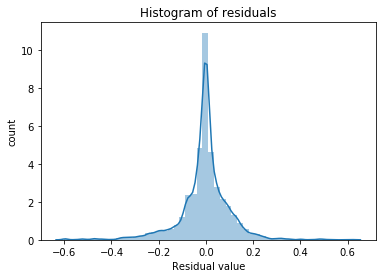

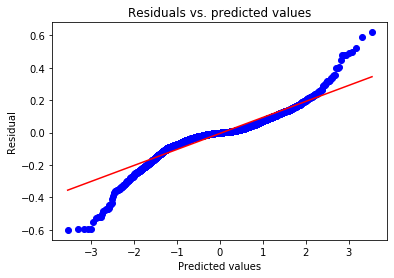

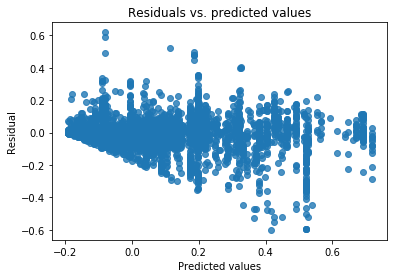

[0.01092636859444143,
 0.10452927147187735,
 0.06589948169178819,
 0.03688524590163936,
 0.7858992911990429,
 0.785095331287312]

In [110]:
from sklearn.tree import DecisionTreeRegressor

feature_set = ['temp', 'atemp', 'hr', 'instant', 'yr', 'season', 'mnth', 'windspeed', 'workingday', 'weekday', 'holiday', 'weathersit', 'hum', 'time_label']
regressor = DecisionTreeRegressor(random_state=0)
total_rows = len(refined_df)
num_training_rows = int(total_rows*.8)
train = refined_df[:num_training_rows]
test = refined_df[num_training_rows:]
regressor.fit(train[feature_set], train['cnt'])
predictions = regressor.predict(test[feature_set])
#cross_val_score(regressor, test[feature_set],test['cnt'],cv=10)
tree_mse = mean_squared_error(test['cnt'], predictions)
tree_rmse = np.sqrt(tree_mse)
evaluate_model(predictions, test['cnt'].to_numpy(),feature_set)
#print(tree_rmse)
#plt.figure()
#plt.scatter(train[feature_set], train['cnt'], s=20, edgecolor="black", c="darkorange", label="data")
#plt.plot(test[feature_set], predictions, color="cornflowerblue", label="max_depth=2", linewidth=2)
#plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
#plt.title("Decision Tree Regression")
#plt.legend()
#plt.show()

## Questions:
## How do we assess the decision tree regressor?
## Is the decision tree regressor better or worse than the linear regressor?